### Overview

Over the past two decades, the U.S. health care community has taken significant strides in the direction of [value-based care](https://catalyst.nejm.org/doi/full/10.1056/CAT.17.0558).  The federal government and private insurers have started to incentivize providers who deliver high-quality care at low cost, rather than on a fee-for-service basis.  Networks of providers and hospitals who coordinate care are able to improve health outcomes and reduce health care costs.  In payment systems such as [Medicare's Accountable Care Organization (ACO) program](https://innovation.cms.gov/innovation-models/aco), provider networks that reduce costs are entitled to a share of the savings to the insurer.

One of the greatest benefits of coordinated care is a reduction in hospitalizations due to better management of chronic diseases.  Thus, a major goal for ACOs is to identify patients who are at high risk for hospitalizations and target them for outreach.

This project explores the ways in which data mining and machine learning can help ACOs identify high-risk patients using the data in their electronic health records (EHRs) and billing systems.  A recent [study](https://www.ajmc.com/view/predicting-hospitalizations-from-electronic-health-record-data) in the American Journal of Managed Care


In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils as ut

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/learn-env/lib/python

In [2]:
# import df with continuous variables

yrs_df_3 = pd.read_csv('data/yrs_df').set_index('SEQN')
yrs_df_3


,RIDAGEYR,yrs_osteoarth,yrs_other_arth,yrs_heart_fail,yrs_heart_cond,ever_had_COPD,yrs_emphysema,yrs_chron_bronc,yrs_asthma,yrs_diabetes,yrs_taking_ins,HUQ071
SEQN,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93705.00000,66.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
102952.00000,70.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
102953.00000,42.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
102954.00000,41.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [3]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)


0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

In [4]:
target_ratio = pd.DataFrame(yrs_df_3['HUQ071'].value_counts(normalize=True))
target_ratio.rename(index = {0.00000: 'No', 1.00000: 'Yes'}, inplace=True)
target_ratio

,HUQ071
No,0.91455
Yes,0.08545


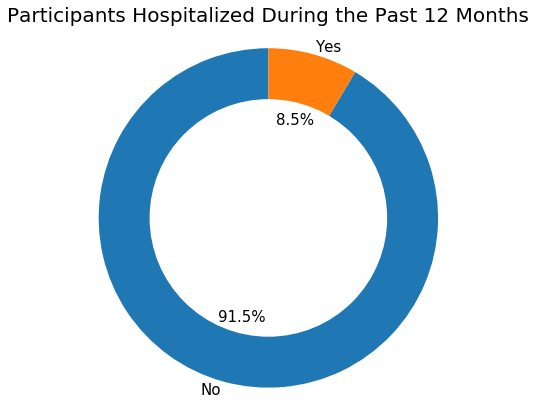

In [5]:
# plot donought chart to show target distribution
# minority class is very small

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(target_ratio['HUQ071'], 
        labels=target_ratio.index,
#        colors=['tab:blue', 'tab:orange'],
        autopct='%1.1f%%',
        labeldistance=1.05,
        startangle=90,
        textprops = {"fontsize":15})
ax1.set_title('Participants Hospitalized During the Past 12 Months', pad=10, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.savefig('images/label-distribution-pie', bbox_inches='tight')

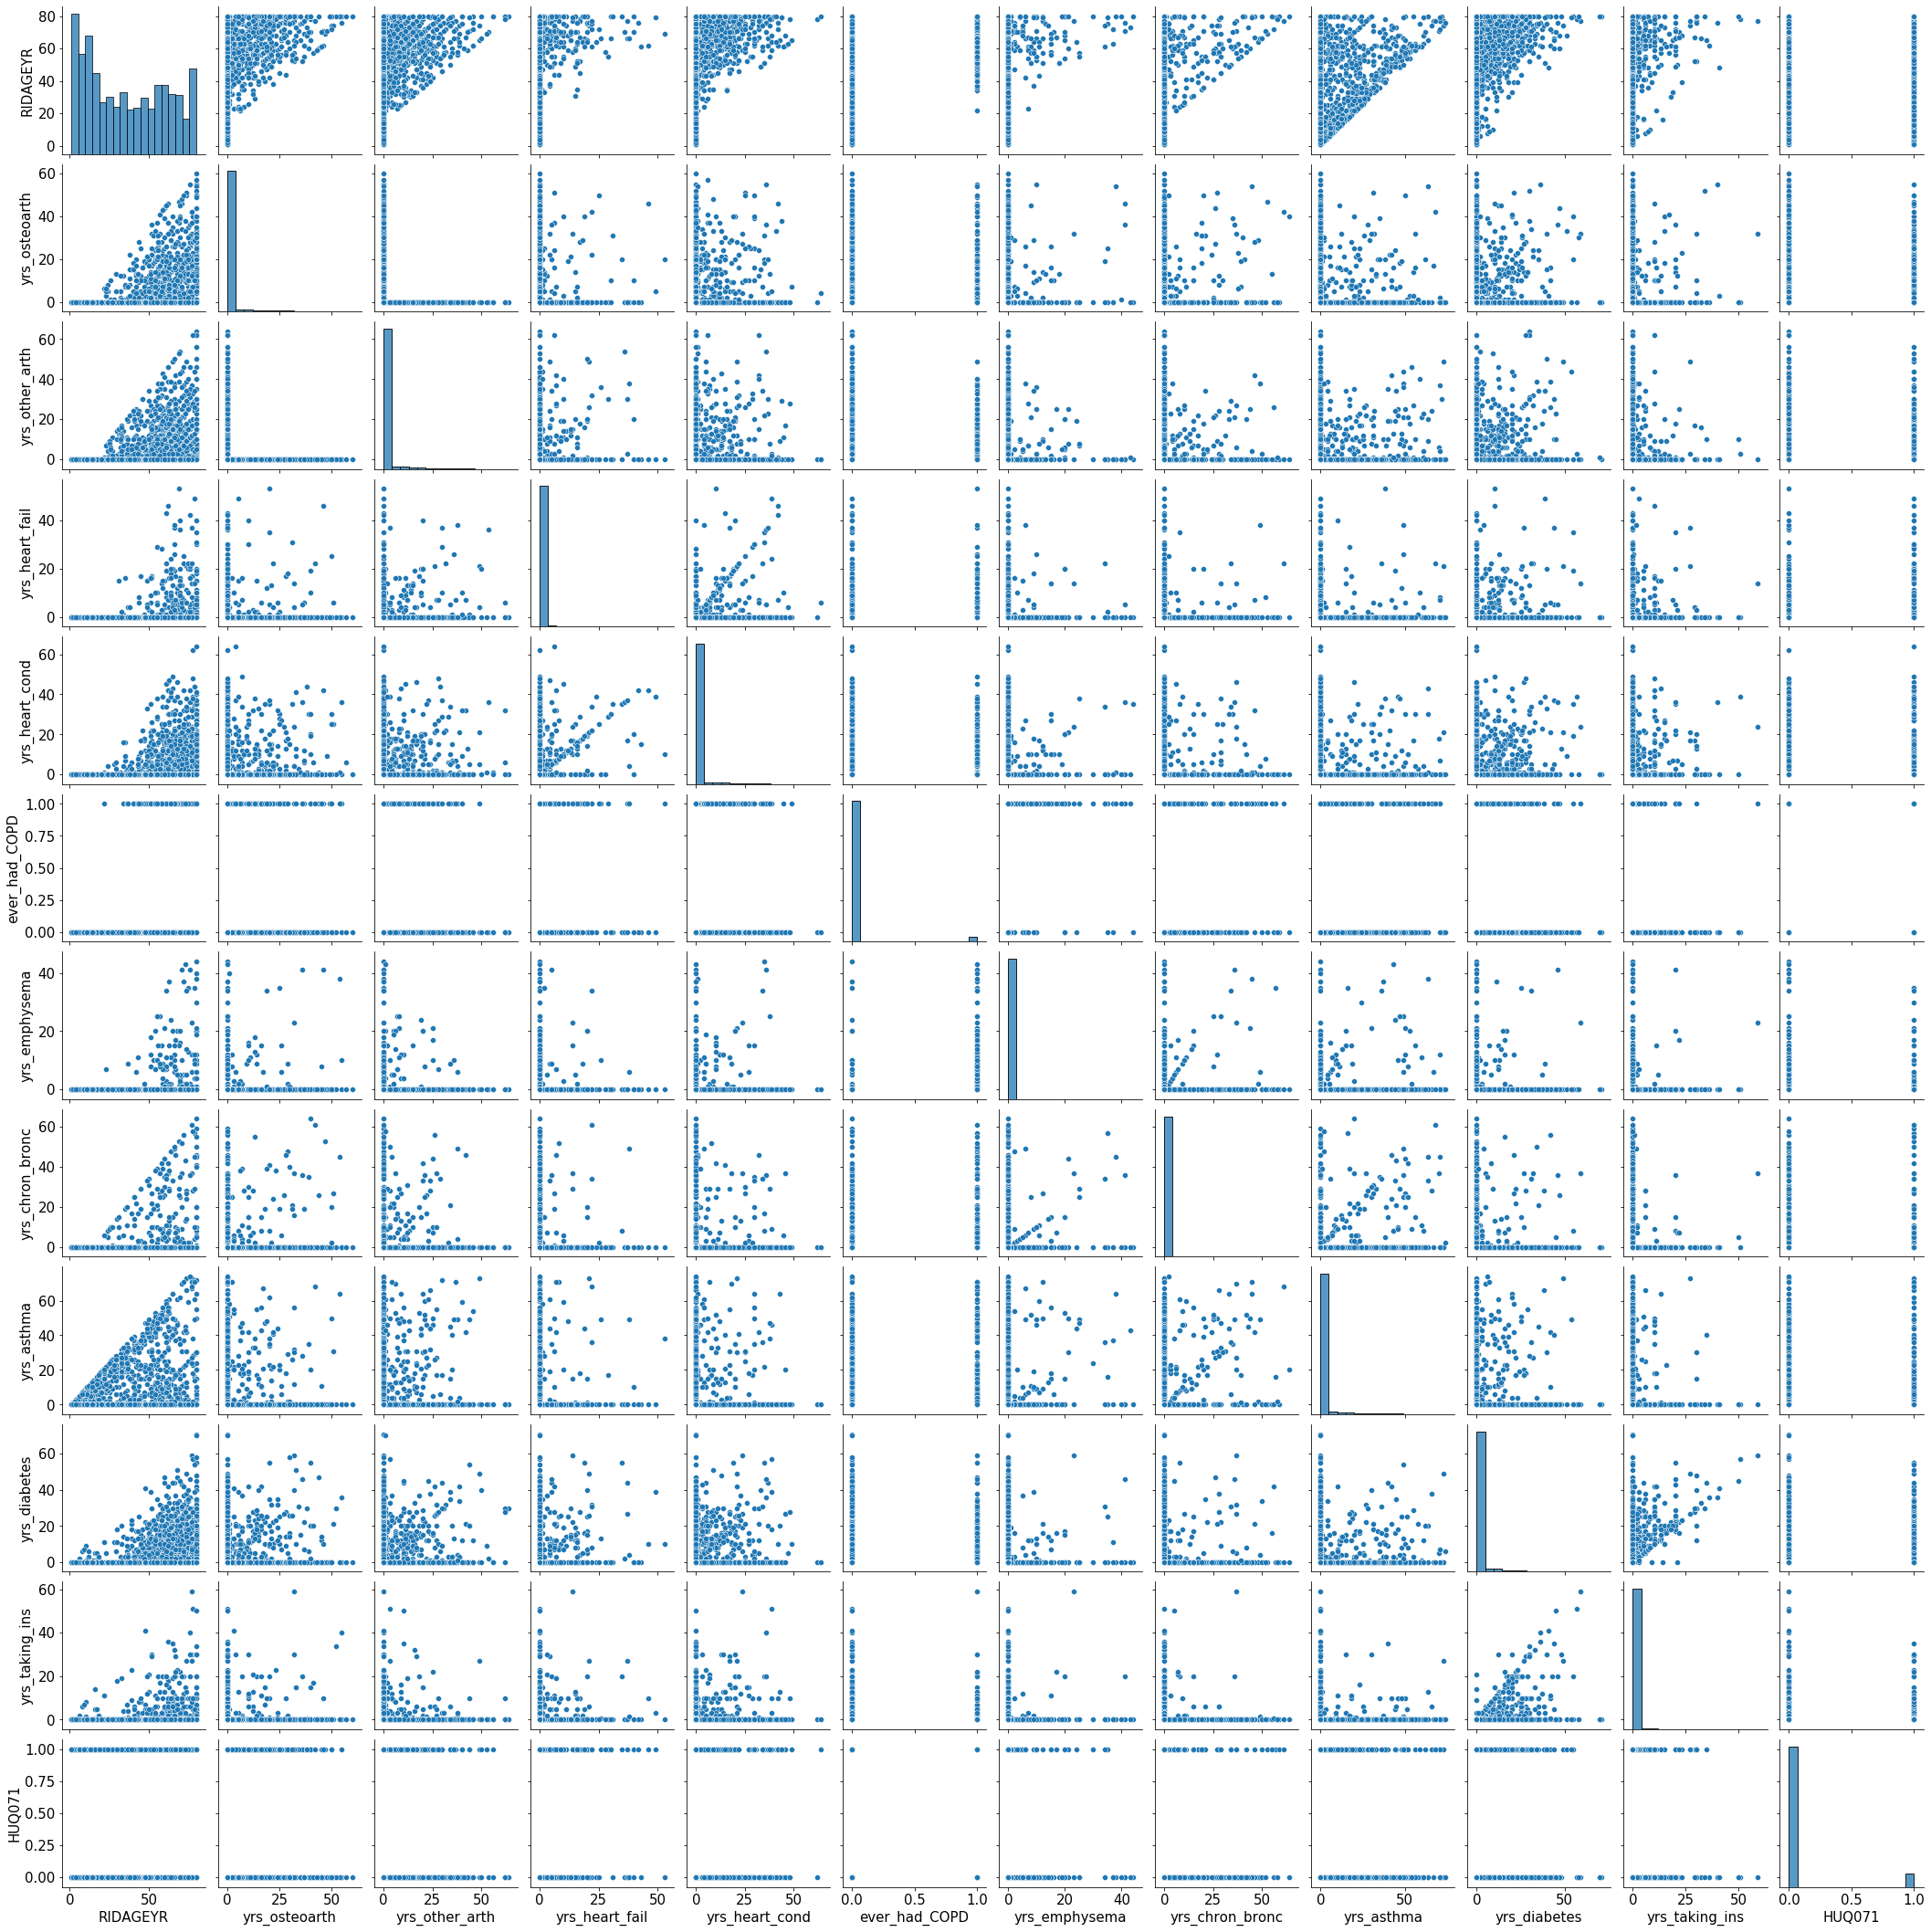

In [6]:
sns.pairplot(yrs_df_3)


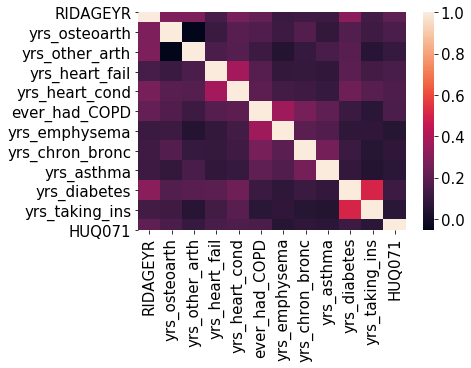

In [7]:
corr = yrs_df_3.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [8]:
# define X and y

X = yrs_df_3.drop(columns = ['HUQ071'])
y = yrs_df_3['HUQ071']


In [9]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


# look at cross_validate instead of doing by hand

In [10]:
def k_fold_validator(X, y, classifier, cv=5):

    """Uses k-fold cross-validation to calculate the mean recall, precision, and f1 scores 
    for train and test sets for a model.  Also plots a confusion matrix for each test set.
    
    Parameters
    ----------
    
    X : DataFrame, Predictors
    
    y : series, Labels assigned
    
    classifier : An instance of a classifier.
    
    cv : int, How many folds to use when cross-validating.  Default = 5.
    
    Returns
    -------
    
    No objects returned.
    
    Prints mean recall, precision, and f1 scores for train and test sets.
    
    Plots a confusion matrix for each test set."""
    
    kf = KFold(n_splits=cv, random_state=807, shuffle=True)
    clf = classifier

    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    
    print('Classifier:', clf)
    print('Cross-validation folds:', cv)
    
    print('\n')
    print('Mean ROC-AUC Score:', round(cross_val_score(clf, X, y, scoring='roc_auc').mean(), 3))
    
    
    for train_index, test_index in kf.split(X):

        X_tr, X_test = X.iloc[train_index].astype(str), X.iloc[test_index].astype(str)
        y_tr, y_test = y.iloc[train_index].astype(str), y.iloc[test_index].astype(str)
        
        clf.fit(X_tr, y_tr)

        y_pred_tr = clf.predict(X_tr)
        y_pred_test = clf.predict(X_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_f1_scores.append(f1_score(y_tr, y_pred_tr, pos_label='1.0'))       
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='1.0'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='1.0'))
        test_f1_scores.append(f1_score(y_test, y_pred_test, pos_label='1.0'))       
        
        plot_confusion_matrix(clf, X_test, y_test)
        plt.title('Test set')
        
    print('\n')
    
    print('Train mean recall: {} +/- {}'.format(round(pd.Series(train_recall_scores).mean(), 2), 
                                               round(pd.Series(train_recall_scores).std(), 2)))
    
    print('Train mean precision: {} +/- {}'.format(round(pd.Series(train_precision_scores).mean(), 2),
                                                  round(pd.Series(train_precision_scores).std(), 2)))
    
    print('Train mean F1: {} +/- {}'.format(round(pd.Series(train_f1_scores).mean(), 2),
                                           round(pd.Series(train_f1_scores).std(), 2)))
    print('\n')
    
    print('Test mean recall: {} +/- {}'.format(round(pd.Series(test_recall_scores).mean(), 2),
                                               round(pd.Series(test_recall_scores).std(), 2)))
    
    print('Test mean precision: {} +/- {}'.format(round(pd.Series(test_precision_scores).mean(), 2),
                                                  round(pd.Series(test_precision_scores).std(), 2)))
    
    print('Test mean F1: {} +/- {}'.format(round(pd.Series(test_f1_scores).mean(), 2),
                                           round(pd.Series(test_f1_scores).std(), 2)))

In [11]:
def order_features(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[0][n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df


def order_features_tree(weights, X_train):
    
    coef_dict = {}

    for n, c in enumerate(X_train.columns):
        coef_dict[c]=round(weights[n],4)

    sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
    df = pd.DataFrame.from_dict(sorted_coef_dict, orient='index', columns=['weight'])
    df['abs_weight']=np.abs(df['weight'])
    weights_df = df.sort_values(by = 'abs_weight', ascending=False)
    
    return weights_df


def k_fold_validator_2(X, y, classifier, cv=5):

    """Uses k-fold cross-validation to calculate the mean recall, precision, and f1 scores 
    for train and test sets for a model.  Also plots a confusion matrix for each test set.
    
    Parameters
    ----------
    
    X : DataFrame, Predictors
    
    y : series, Labels assigned
    
    classifier : An instance of a classifier.
    
    cv : int, How many folds to use when cross-validating.  Default = 5.
    
    Returns
    -------
    
    No objects returned.
    
    Prints mean recall, precision, and f1 scores for train and test sets.
    
    Plots a confusion matrix for each test set."""
    
    scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    kf = KFold(n_splits=cv, random_state=807, shuffle=True)
    clf = classifier

    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    
    print('Classifier:', clf)
    print('Cross-validation folds:', cv)
    
    print('\n')
    print('Mean ROC-AUC Score:', round(cross_val_score(clf, X_scaled, y, scoring='roc_auc').mean(), 3))
    
    
    for train_index, test_index in kf.split(X_scaled):

        X_tr, X_test = X_scaled.iloc[train_index].astype(str), X_scaled.iloc[test_index].astype(str)
        y_tr, y_test = y.iloc[train_index].astype(str), y.iloc[test_index].astype(str)
        
        clf.fit(X_tr, y_tr)

        y_pred_tr = clf.predict(X_tr)
        y_pred_test = clf.predict(X_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_precision_scores.append(precision_score(y_tr, y_pred_tr, pos_label='1.0'))
        train_f1_scores.append(f1_score(y_tr, y_pred_tr, pos_label='1.0'))       
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='1.0'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='1.0'))
        test_f1_scores.append(f1_score(y_test, y_pred_test, pos_label='1.0'))       
        
        plot_confusion_matrix(clf, X_test, y_test)
        plt.title('Test set')
        
    print('\n')
    
    print('Train mean recall: {} +/- {}'.format(round(pd.Series(train_recall_scores).mean(), 2), 
                                               round(pd.Series(train_recall_scores).std(), 2)))
    
    print('Train mean precision: {} +/- {}'.format(round(pd.Series(train_precision_scores).mean(), 2),
                                                  round(pd.Series(train_precision_scores).std(), 2)))
    
    print('Train mean F1: {} +/- {}'.format(round(pd.Series(train_f1_scores).mean(), 2),
                                           round(pd.Series(train_f1_scores).std(), 2)))
    print('\n')
    
    print('Test mean recall: {} +/- {}'.format(round(pd.Series(test_recall_scores).mean(), 2),
                                               round(pd.Series(test_recall_scores).std(), 2)))
    
    print('Test mean precision: {} +/- {}'.format(round(pd.Series(test_precision_scores).mean(), 2),
                                                  round(pd.Series(test_precision_scores).std(), 2)))
    
    print('Test mean F1: {} +/- {}'.format(round(pd.Series(test_f1_scores).mean(), 2),
                                           round(pd.Series(test_f1_scores).std(), 2)))
    print('\n')
    
    if type(clf) == DecisionTreeClassifier:
        features = order_features_tree(clf.feature_importances_, X_scaled)
    elif type(clf) == KNeighborsClassifier:
        pass
    else:
        features = order_features(clf.coef_, X_scaled)
    
    if type(clf) != KNeighborsClassifier:
        print('Feature weights:', '\n', features, '\n')
        print('Confusion matrices for each fold test set:', '\n')
    

Classifier: LogisticRegression(max_iter=10000)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.719


Train mean recall: 0.03 +/- 0.01
Train mean precision: 0.59 +/- 0.07
Train mean F1: 0.06 +/- 0.02


Test mean recall: 0.02 +/- 0.01
Test mean precision: 0.45 +/- 0.18
Test mean F1: 0.05 +/- 0.02


Feature weights: 
                   weight  abs_weight
RIDAGEYR         1.67940     1.67940
yrs_heart_fail   1.61490     1.61490
yrs_heart_cond   1.60670     1.60670
yrs_osteoarth    1.48310     1.48310
yrs_other_arth   0.98410     0.98410
ever_had_COPD    0.71110     0.71110
yrs_taking_ins   0.66050     0.66050
yrs_chron_bronc  0.21340     0.21340
yrs_emphysema   -0.10480     0.10480
yrs_asthma       0.08680     0.08680
yrs_diabetes     0.06540     0.06540 

Confusion matrices for each fold test set: 



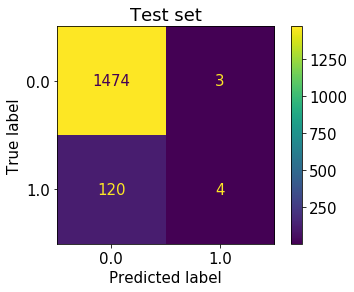

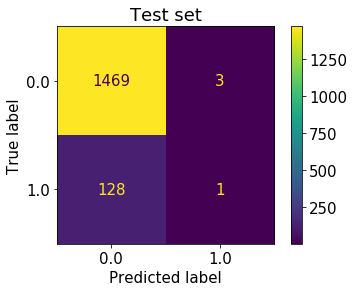

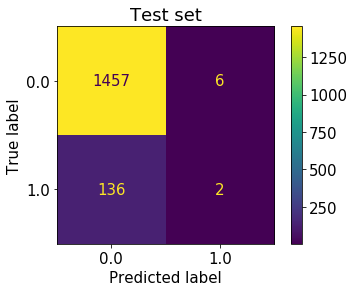

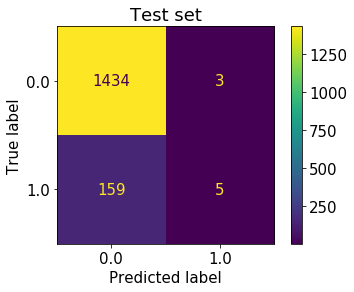

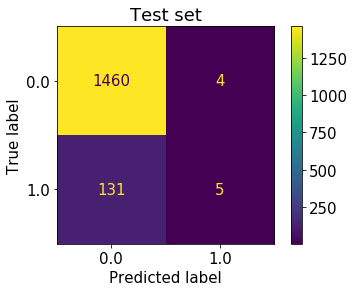

In [12]:
k_fold_validator_2(X=X_training, y=y_training, classifier=LogisticRegression(max_iter=10000), cv=5)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.55


Train mean recall: 0.3 +/- 0.01
Train mean precision: 0.28 +/- 0.0
Train mean F1: 0.29 +/- 0.01


Test mean recall: 0.3 +/- 0.01
Test mean precision: 0.27 +/- 0.02
Test mean F1: 0.28 +/- 0.01


Feature weights: 
                  weight  abs_weight
yrs_emphysema   5.41350     5.41350
yrs_heart_fail  5.38400     5.38400
yrs_taking_ins  4.96720     4.96720
yrs_chron_bronc 4.68530     4.68530
yrs_heart_cond  3.95170     3.95170
yrs_osteoarth   3.58130     3.58130
yrs_diabetes    3.49430     3.49430
yrs_other_arth  3.48160     3.48160
yrs_asthma      3.29190     3.29190
ever_had_COPD   3.06700     3.06700
RIDAGEYR        0.24480     0.24480 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


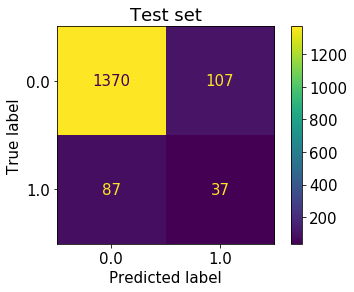

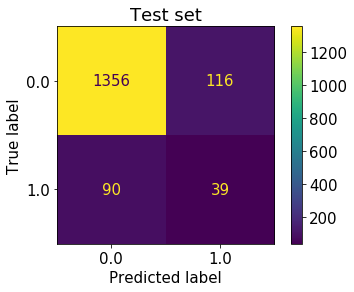

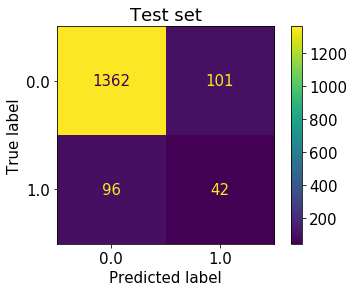

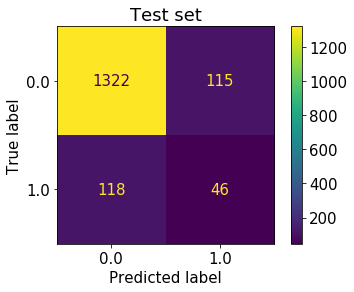

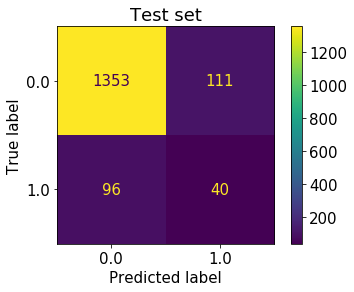

In [13]:
# try a complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.699


Train mean recall: 0.11 +/- 0.02
Train mean precision: 0.79 +/- 0.09
Train mean F1: 0.19 +/- 0.02


Test mean recall: 0.05 +/- 0.03
Test mean precision: 0.35 +/- 0.07
Test mean F1: 0.09 +/- 0.04


Feature weights: 
                  weight  abs_weight
yrs_heart_cond  0.41610     0.41610
RIDAGEYR        0.23230     0.23230
yrs_heart_fail  0.13160     0.13160
yrs_diabetes    0.05520     0.05520
yrs_osteoarth   0.04930     0.04930
yrs_taking_ins  0.04270     0.04270
yrs_chron_bronc 0.03740     0.03740
yrs_other_arth  0.01260     0.01260
yrs_asthma      0.01140     0.01140
yrs_emphysema   0.01130     0.01130
ever_had_COPD   0.00000     0.00000 

Confusion matrices for each fold test set: 



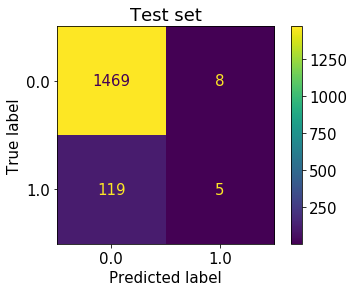

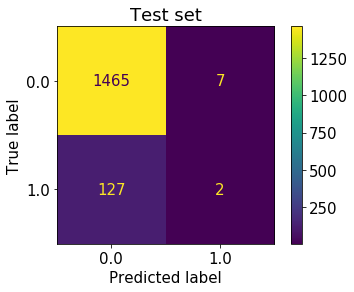

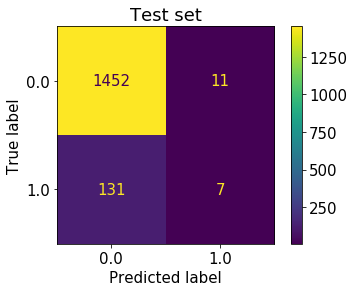

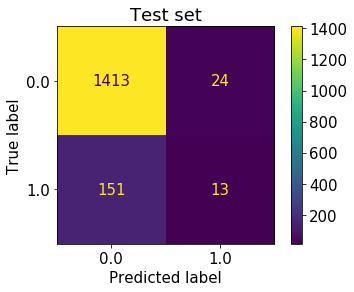

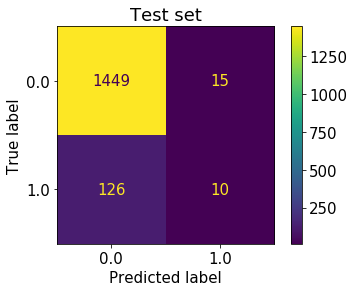

In [14]:
# try a decision tree

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [15]:
# other features to try:
# cancer
# lang spoken at home
# depression
# alcohol-related disorders
# childbirth - exclude 70 ppl who had babies in the past 12 months? RHQ197 - How many months ago have baby?
# sickle cell
# language

# other things to try:
# svm
# neural net

In [16]:
binary_df = pd.read_csv('data/binary_df').set_index('SEQN')

In [17]:
# minority class is just 8.5 %

binary_df['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

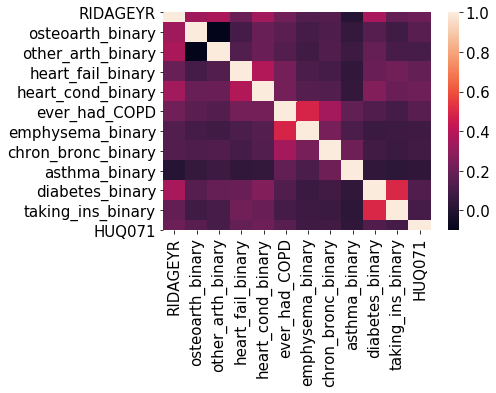

In [18]:
corr = binary_df.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [19]:
# define X and y

X = binary_df.drop(columns = 'HUQ071')
y = binary_df['HUQ071']

In [20]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.604


Train mean recall: 0.41 +/- 0.02
Train mean precision: 0.26 +/- 0.02
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.41 +/- 0.05
Test mean precision: 0.26 +/- 0.03
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.66390     4.66390
heart_fail_binary  4.21200     4.21200
chron_bronc_binary 4.05590     4.05590
taking_ins_binary  3.69590     3.69590
ever_had_COPD      3.56530     3.56530
heart_cond_binary  2.81920     2.81920
osteoarth_binary   2.62620     2.62620
asthma_binary      2.36340     2.36340
diabetes_binary    2.33120     2.33120
other_arth_binary  2.24040     2.24040
RIDAGEYR           0.74310     0.74310 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


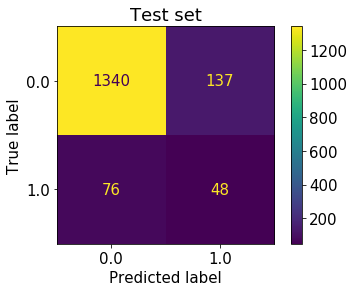

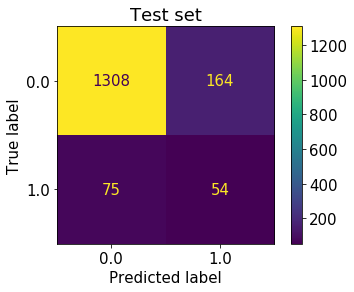

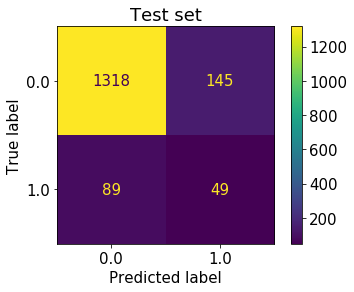

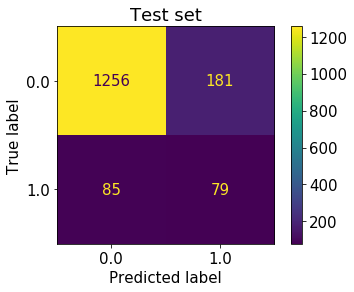

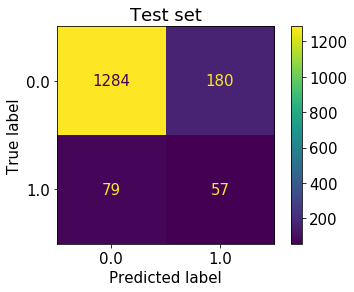

In [21]:
# try a complement naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: LogisticRegression()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.729


Train mean recall: 0.05 +/- 0.01
Train mean precision: 0.53 +/- 0.04
Train mean F1: 0.09 +/- 0.01


Test mean recall: 0.05 +/- 0.01
Test mean precision: 0.5 +/- 0.12
Test mean F1: 0.09 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           1.28300     1.28300
heart_fail_binary  0.84880     0.84880
heart_cond_binary  0.76470     0.76470
osteoarth_binary   0.74130     0.74130
ever_had_COPD      0.47160     0.47160
other_arth_binary  0.33810     0.33810
taking_ins_binary  0.24740     0.24740
asthma_binary      0.10540     0.10540
chron_bronc_binary 0.08960     0.08960
diabetes_binary    0.08380     0.08380
emphysema_binary   0.04380     0.04380 

Confusion matrices for each fold test set: 



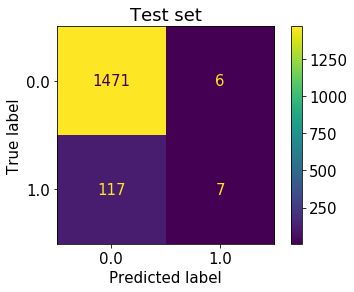

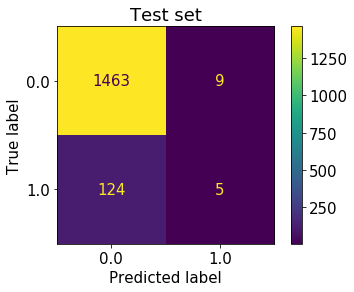

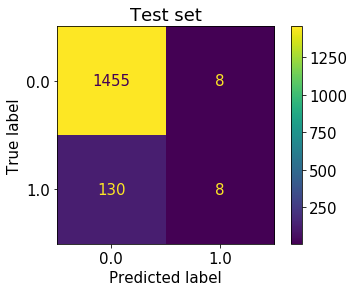

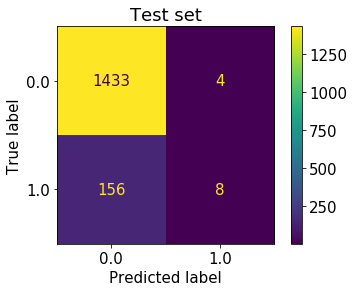

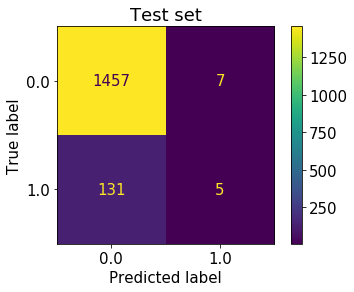

In [22]:
# try a Logistic Regression

logreg = LogisticRegression()

k_fold_validator_2(X_training, y_training, logreg)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.695


Train mean recall: 0.08 +/- 0.01
Train mean precision: 0.73 +/- 0.02
Train mean F1: 0.14 +/- 0.02


Test mean recall: 0.04 +/- 0.0
Test mean precision: 0.41 +/- 0.08
Test mean F1: 0.08 +/- 0.01


Feature weights: 
                     weight  abs_weight
heart_cond_binary  0.36620     0.36620
RIDAGEYR           0.33790     0.33790
diabetes_binary    0.08140     0.08140
heart_fail_binary  0.08070     0.08070
osteoarth_binary   0.03640     0.03640
ever_had_COPD      0.02520     0.02520
chron_bronc_binary 0.01960     0.01960
emphysema_binary   0.01660     0.01660
asthma_binary      0.01630     0.01630
taking_ins_binary  0.01020     0.01020
other_arth_binary  0.00950     0.00950 

Confusion matrices for each fold test set: 



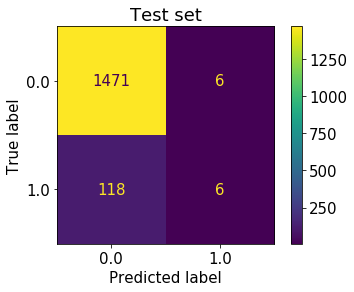

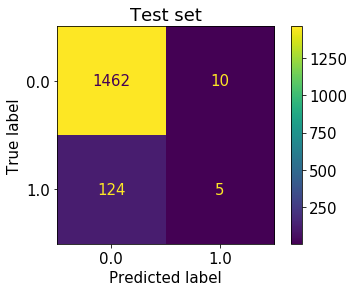

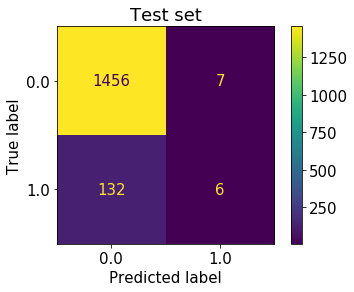

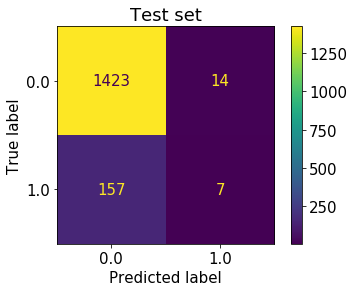

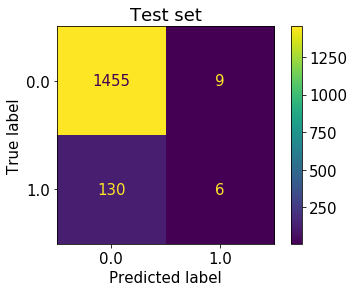

In [23]:
# try a decision tree

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [24]:
# try with updated non-birth hospitalizations

binary_df_2 = pd.read_csv('data/binary_df_2').set_index('SEQN')
binary_df_2

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp
SEQN,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
102952.00000,70.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
102953.00000,42.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
102954.00000,41.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [25]:
# define X and y

X = binary_df_2.drop(columns = 'updated_hosp')
y = binary_df_2['updated_hosp']

In [26]:
# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.618


Train mean recall: 0.44 +/- 0.01
Train mean precision: 0.26 +/- 0.02
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.44 +/- 0.06
Test mean precision: 0.26 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.66730     4.66730
heart_fail_binary  4.21540     4.21540
chron_bronc_binary 4.05940     4.05940
taking_ins_binary  3.69930     3.69930
ever_had_COPD      3.56190     3.56190
heart_cond_binary  2.82260     2.82260
osteoarth_binary   2.62960     2.62960
asthma_binary      2.35870     2.35870
diabetes_binary    2.33260     2.33260
other_arth_binary  2.24380     2.24380
RIDAGEYR           0.74180     0.74180 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


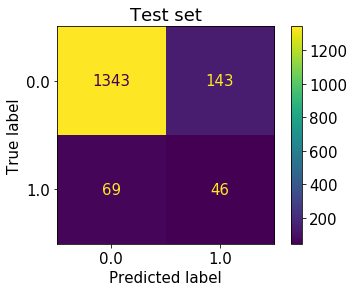

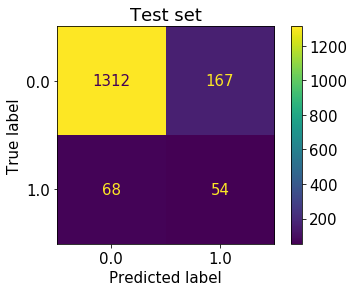

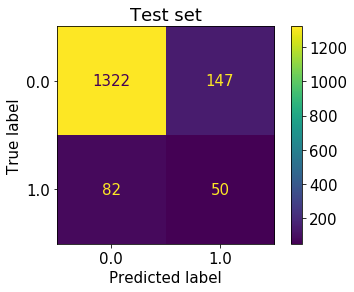

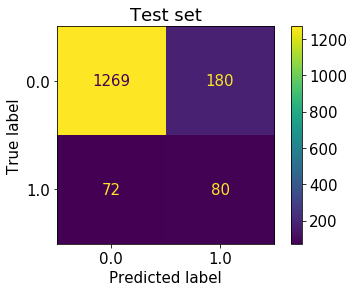

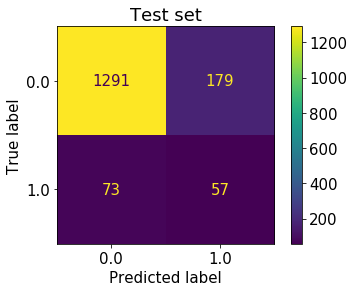

In [27]:
# try a complement naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: LogisticRegression()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.744


Train mean recall: 0.05 +/- 0.01
Train mean precision: 0.52 +/- 0.02
Train mean F1: 0.1 +/- 0.01


Test mean recall: 0.05 +/- 0.01
Test mean precision: 0.48 +/- 0.11
Test mean F1: 0.09 +/- 0.02


Feature weights: 
                     weight  abs_weight
RIDAGEYR           1.43110     1.43110
heart_fail_binary  0.85820     0.85820
osteoarth_binary   0.80540     0.80540
heart_cond_binary  0.79030     0.79030
ever_had_COPD      0.45080     0.45080
other_arth_binary  0.40560     0.40560
taking_ins_binary  0.25910     0.25910
chron_bronc_binary 0.12120     0.12120
diabetes_binary    0.09500     0.09500
emphysema_binary   0.07600     0.07600
asthma_binary      0.07360     0.07360 

Confusion matrices for each fold test set: 



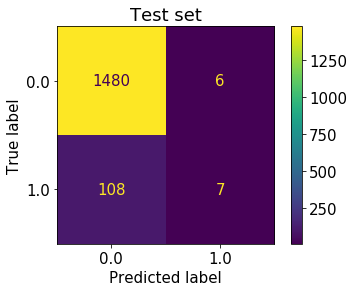

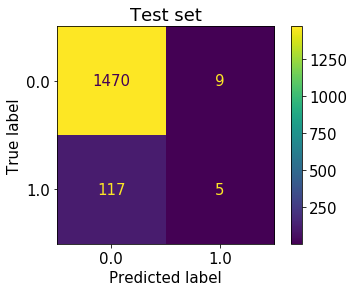

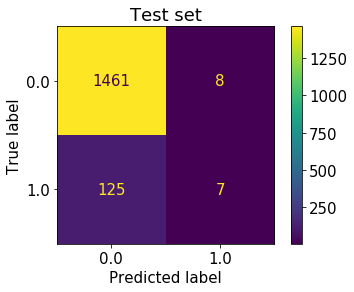

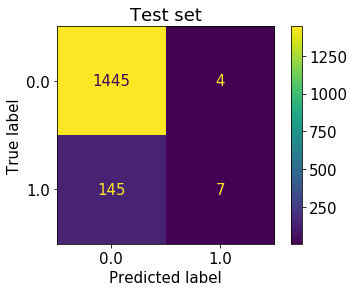

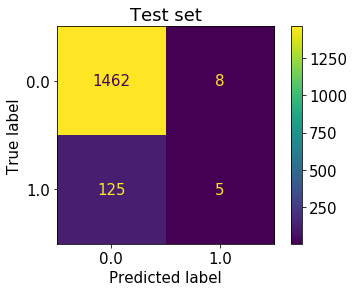

In [28]:
# try a Logistic Regression

logreg = LogisticRegression()

k_fold_validator_2(X_training, y_training, logreg)

Classifier: DecisionTreeClassifier(max_depth=6, min_samples_split=15)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.693


Train mean recall: 0.09 +/- 0.02
Train mean precision: 0.73 +/- 0.04
Train mean F1: 0.15 +/- 0.03


Test mean recall: 0.05 +/- 0.01
Test mean precision: 0.42 +/- 0.12
Test mean F1: 0.09 +/- 0.01


Feature weights: 
                     weight  abs_weight
heart_cond_binary  0.37140     0.37140
RIDAGEYR           0.32190     0.32190
heart_fail_binary  0.08210     0.08210
diabetes_binary    0.07670     0.07670
osteoarth_binary   0.05750     0.05750
ever_had_COPD      0.02280     0.02280
chron_bronc_binary 0.01900     0.01900
emphysema_binary   0.01600     0.01600
asthma_binary      0.01340     0.01340
taking_ins_binary  0.00990     0.00990
other_arth_binary  0.00920     0.00920 

Confusion matrices for each fold test set: 



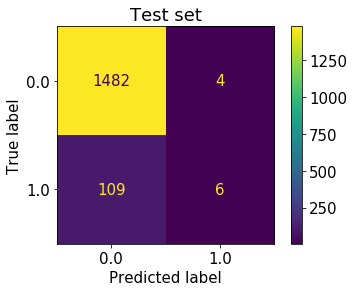

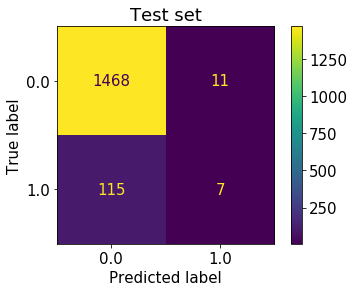

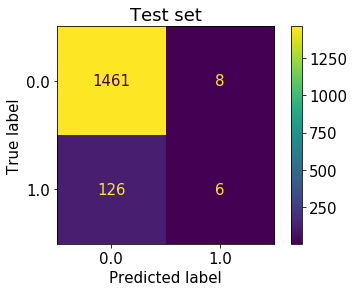

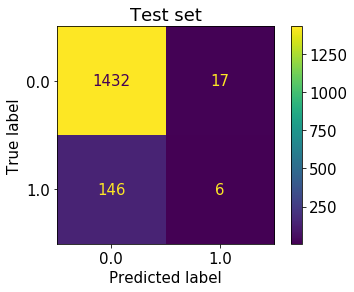

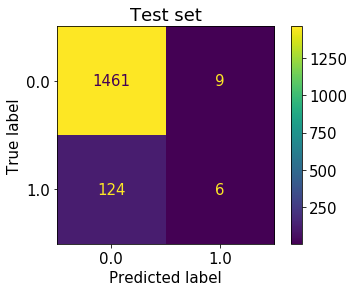

In [29]:
# try a decision tree
# tried to prune tree without success

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=15)

k_fold_validator_2(X_training, y_training, tree)

In [30]:
# add race

binary_df_3 = pd.read_csv('data/binary_df_3').set_index('SEQN')
binary_df_3.head(200)

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0
SEQN,,,,,,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0
93708.00000,66.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93709.00000,75.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0
93711.00000,56.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93712.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0


In [31]:
# define X and y

X = binary_df_3.drop(columns = 'updated_hosp')
y = binary_df_3['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.716


Train mean recall: 0.52 +/- 0.02
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.52 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.38700     5.38700
heart_fail_binary  4.93500     4.93500
chron_bronc_binary 4.77900     4.77900
taking_ins_binary  4.41900     4.41900
ever_had_COPD      4.28160     4.28160
heart_cond_binary  3.54220     3.54220
osteoarth_binary   3.34920     3.34920
asthma_binary      3.07830     3.07830
diabetes_binary    3.05220     3.05220
RIDRETH3_2.0       3.04830     3.04830
other_arth_binary  2.96340     2.96340
RIDRETH3_6.0       2.58670     2.58670
RIDRETH3_1.0       2.48310     2.48310
RIDRETH3_4.0       2.06210     2.06210
RIDRETH3_3.0       1.71660     1.71660
RIDAGEYR           1.46140     1.46140 

Confusion matrices for each fold tes

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


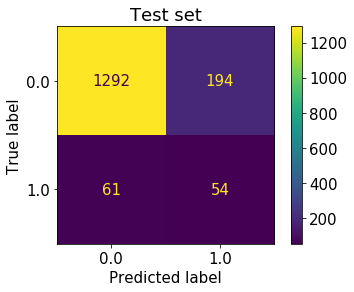

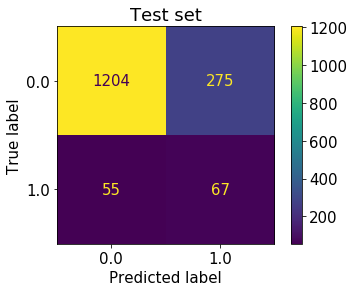

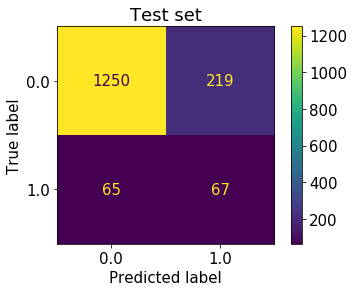

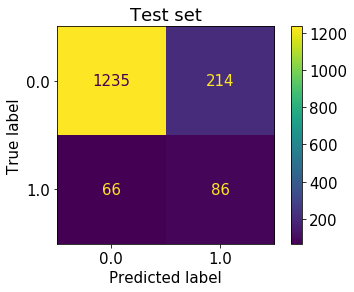

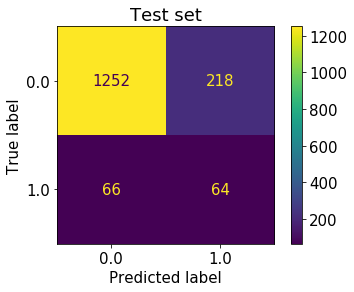

In [32]:
CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

In [33]:
# add number of prescriptions per patient

binary_df_4 = pd.read_csv('data/binary_df_4').set_index('SEQN')
binary_df_4.head(200)

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx
SEQN,,,,,,,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000
93708.00000,66.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,3.00000
93709.00000,75.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,4.00000
93711.00000,56.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93712.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0,0.00000


In [34]:
# define X and y

X = binary_df_4.drop(columns = ['updated_hosp'])
y = binary_df_4['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)



Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.727


Train mean recall: 0.54 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.53 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.41750     5.41750
heart_fail_binary  4.96550     4.96550
chron_bronc_binary 4.80950     4.80950
taking_ins_binary  4.44950     4.44950
ever_had_COPD      4.31210     4.31210
heart_cond_binary  3.57280     3.57280
num_rx             3.50360     3.50360
osteoarth_binary   3.37970     3.37970
asthma_binary      3.10880     3.10880
diabetes_binary    3.08280     3.08280
RIDRETH3_2.0       3.07880     3.07880
other_arth_binary  2.99400     2.99400
RIDRETH3_6.0       2.61720     2.61720
RIDRETH3_1.0       2.51360     2.51360
RIDRETH3_4.0       2.09260     2.09260
RIDRETH3_3.0       1.74720     1.74720
RIDAGEYR           1.49200     1.49200

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


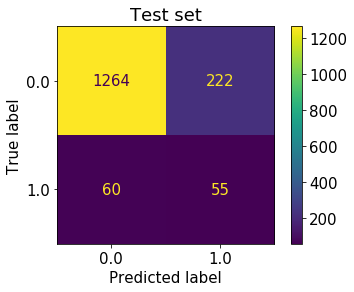

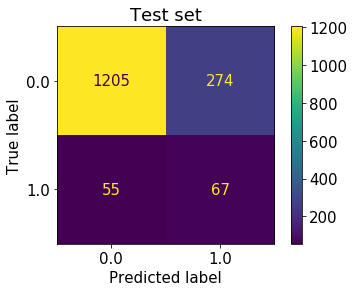

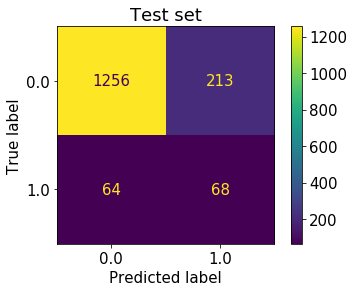

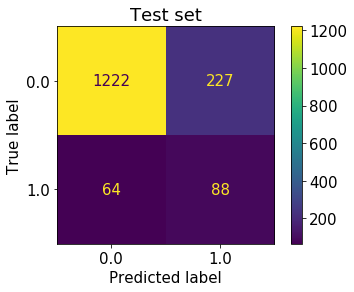

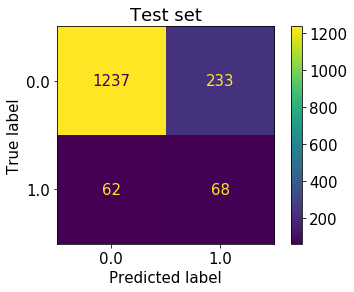

In [35]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.721


Train mean recall: 0.58 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.3 +/- 0.01


Test mean recall: 0.58 +/- 0.03
Test mean precision: 0.2 +/- 0.03
Test mean F1: 0.3 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.90800     4.90800
heart_fail_binary  4.45600     4.45600
chron_bronc_binary 4.30000     4.30000
taking_ins_binary  3.94000     3.94000
ever_had_COPD      3.80260     3.80260
heart_cond_binary  3.06330     3.06330
num_rx             2.99410     2.99410
osteoarth_binary   2.87030     2.87030
asthma_binary      2.59930     2.59930
diabetes_binary    2.57330     2.57330
RIDRETH3_2.0       2.56940     2.56940
other_arth_binary  2.48450     2.48450
RIDRETH3_6.0       2.10780     2.10780
RIDRETH3_1.0       2.00410     2.00410
RIDRETH3_4.0       1.58310     1.58310 

Confusion matrices for each fold test set: 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


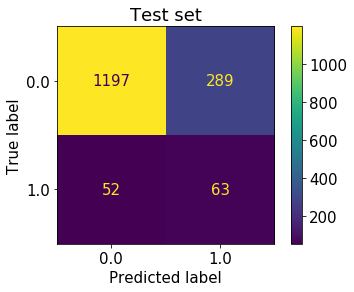

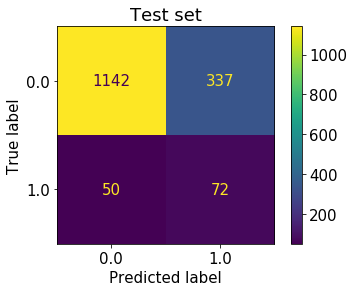

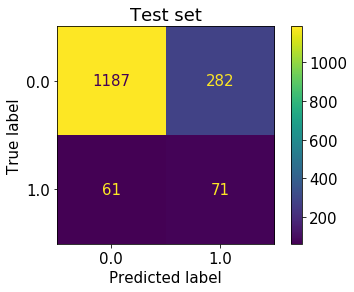

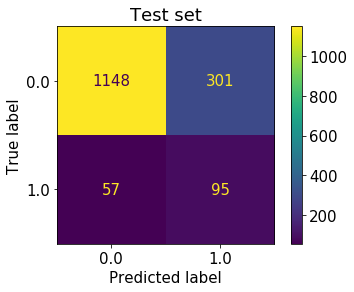

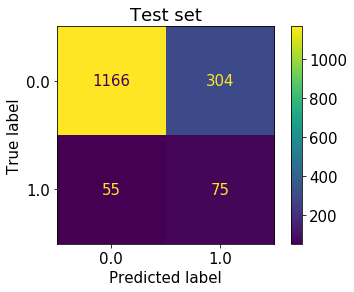

In [36]:
# drop features with lowest weights

# define X and y

X = binary_df_4.drop(columns = ['updated_hosp','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_4['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

k_fold_validator_2(X_training, y_training, CompNB)

In [37]:
binary_df_5 = pd.read_csv('data/binary_df_5').set_index('SEQN')
binary_df_5

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx,unknown_dx
SEQN,,,,,,,,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000,0.00000
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000,0.00000
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.00000,70.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1.00000,0.00000
102953.00000,42.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0,0.00000,0.00000
102954.00000,41.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0.00000,0.00000


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.731


Train mean recall: 0.55 +/- 0.01
Train mean precision: 0.23 +/- 0.01
Train mean F1: 0.33 +/- 0.01


Test mean recall: 0.54 +/- 0.04
Test mean precision: 0.23 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.43040     5.43040
heart_fail_binary  4.97840     4.97840
chron_bronc_binary 4.82240     4.82240
taking_ins_binary  4.46240     4.46240
unknown_dx         4.35940     4.35940
ever_had_COPD      4.32500     4.32500
heart_cond_binary  3.58560     3.58560
num_rx             3.51640     3.51640
osteoarth_binary   3.39260     3.39260
asthma_binary      3.12170     3.12170
diabetes_binary    3.09570     3.09570
RIDRETH3_2.0       3.09170     3.09170
other_arth_binary  3.00680     3.00680
RIDRETH3_6.0       2.63010     2.63010
RIDRETH3_1.0       2.52650     2.52650
RIDRETH3_4.0       2.10550     2.10550
RIDRETH3_3.0       1.76000     1.76000

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


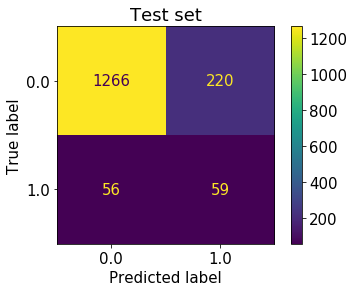

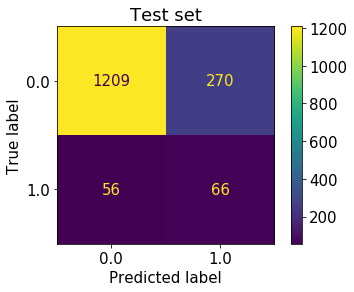

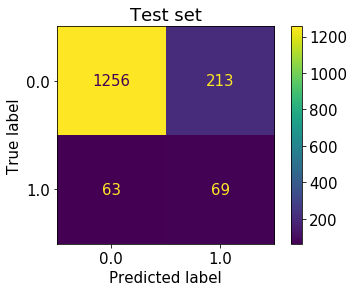

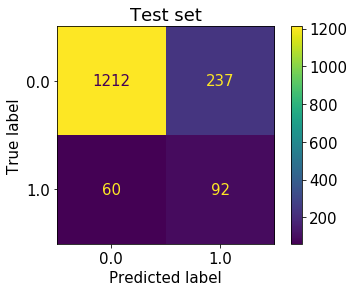

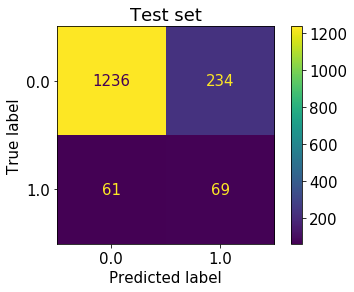

In [38]:
# define X and y

X = binary_df_5.drop(columns = ['updated_hosp'])
y = binary_df_5['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)



Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.722


Train mean recall: 0.59 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.3 +/- 0.01


Test mean recall: 0.58 +/- 0.04
Test mean precision: 0.2 +/- 0.03
Test mean F1: 0.3 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   4.92940     4.92940
heart_fail_binary  4.47740     4.47740
chron_bronc_binary 4.32140     4.32140
taking_ins_binary  3.96140     3.96140
unknown_dx         3.85830     3.85830
ever_had_COPD      3.82400     3.82400
heart_cond_binary  3.08460     3.08460
num_rx             3.01540     3.01540
osteoarth_binary   2.89160     2.89160
asthma_binary      2.62070     2.62070
diabetes_binary    2.59460     2.59460
RIDRETH3_2.0       2.59070     2.59070
other_arth_binary  2.50580     2.50580
RIDRETH3_6.0       2.12910     2.12910
RIDRETH3_1.0       2.02550     2.02550
RIDRETH3_4.0       1.60450     1.60450 

Confusion matrices for each fold test se

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


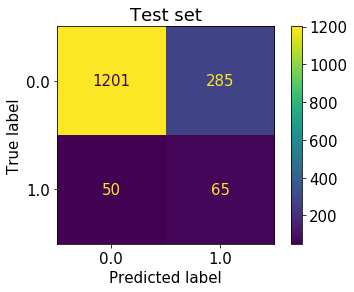

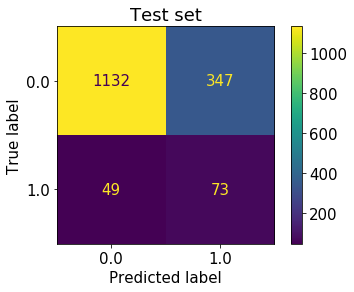

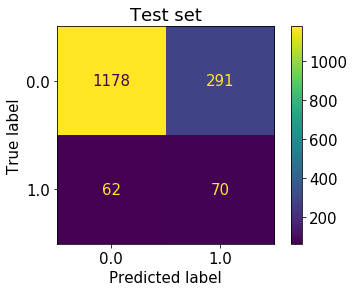

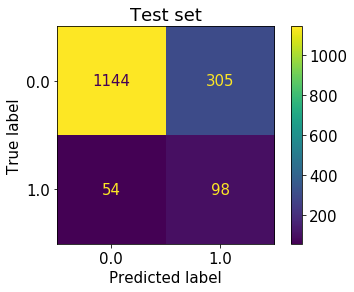

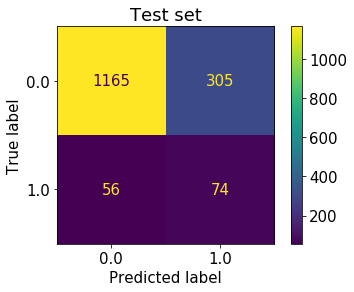

In [39]:
# drop features with lowest weights

# define X and y

X = binary_df_5.drop(columns = ['updated_hosp','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_5['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

k_fold_validator_2(X_training, y_training, CompNB)

In [40]:
# try age buckets instead of continuous age

binary_df_6 = pd.read_csv('data/binary_df_6').set_index('SEQN')
binary_df_6

,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx,unknown_dx,age_0-5,age_18-49,age_50-59,age_60-69,age_70+
SEQN,,,,,,,,,,,,,,,,,,,,,,,
93703.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,1,0,0,0,0
93704.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000,0.00000,1,0,0,0,0
93705.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000,0.00000,0,0,0,1,0
93706.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,0,1,0,0,0
93707.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1.00000,0.00000,0,0,0,0,1
102953.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0,0.00000,0.00000,0,1,0,0,0
102954.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0.00000,0.00000,0,1,0,0,0


In [41]:
# define X and y

X = binary_df_6.drop(columns = ['updated_hosp'])
y = binary_df_6['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.725


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.22 +/- 0.03
Test mean F1: 0.32 +/- 0.04


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.59410     5.59410
heart_fail_binary  5.14210     5.14210
chron_bronc_binary 4.98610     4.98610
taking_ins_binary  4.62610     4.62610
unknown_dx         4.52310     4.52310
ever_had_COPD      4.48870     4.48870
heart_cond_binary  3.74940     3.74940
num_rx             3.68020     3.68020
osteoarth_binary   3.55640     3.55640
asthma_binary      3.28540     3.28540
diabetes_binary    3.25940     3.25940
RIDRETH3_2.0       3.25550     3.25550
other_arth_binary  3.17060     3.17060
age_50-59          3.12120     3.12120
age_0-5            3.11430     3.11430
age_70+            3.11430     3.11430
age_60-69          2.91370     2.91370


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


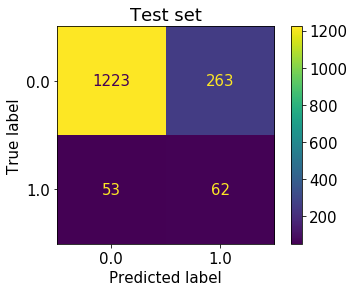

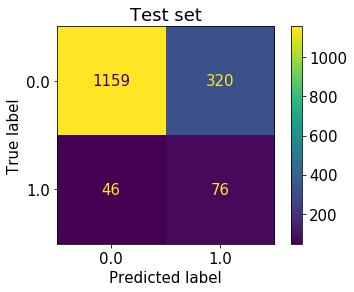

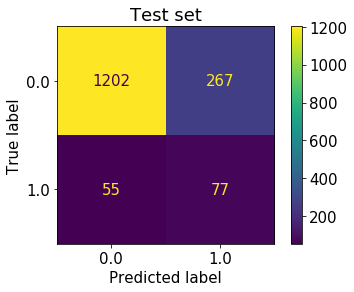

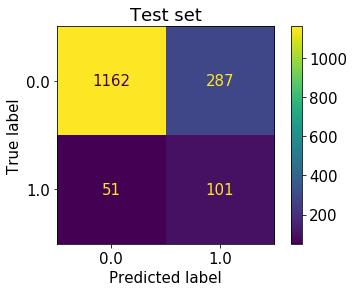

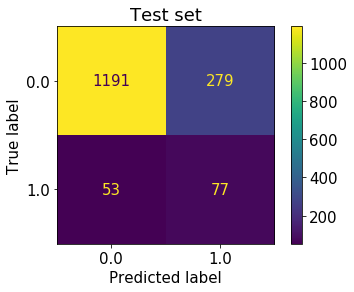

In [42]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

In [43]:
# drop feature with lowest weight

# define X and y

X = binary_df_6.drop(columns = ['updated_hosp', 'age_18-49'])
y = binary_df_6['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.739


Train mean recall: 0.6 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.59 +/- 0.03
Test mean precision: 0.22 +/- 0.03
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.42880     5.42880
heart_fail_binary  4.97680     4.97680
chron_bronc_binary 4.82080     4.82080
taking_ins_binary  4.46080     4.46080
unknown_dx         4.35780     4.35780
ever_had_COPD      4.32340     4.32340
heart_cond_binary  3.58410     3.58410
num_rx             3.51490     3.51490
osteoarth_binary   3.39110     3.39110
asthma_binary      3.12010     3.12010
diabetes_binary    3.09410     3.09410
RIDRETH3_2.0       3.09020     3.09020
other_arth_binary  3.00530     3.00530
age_50-59          2.95590     2.95590
age_0-5            2.94900     2.94900
age_70+            2.94900     2.94900
age_60-69          2.74840     2.74840


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


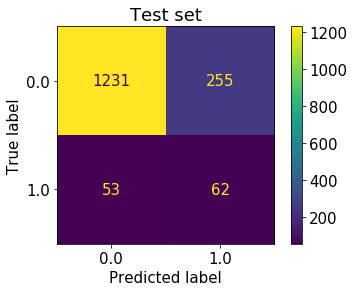

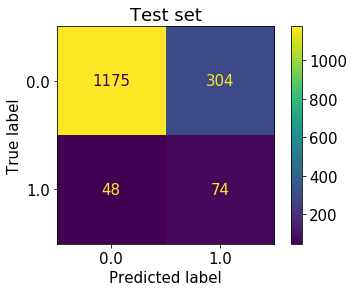

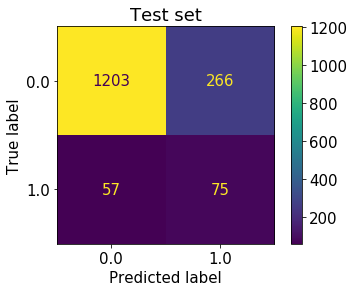

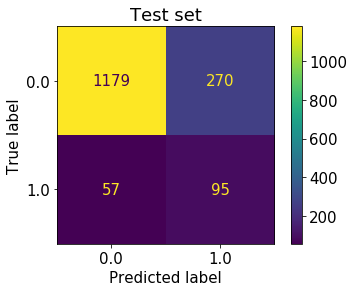

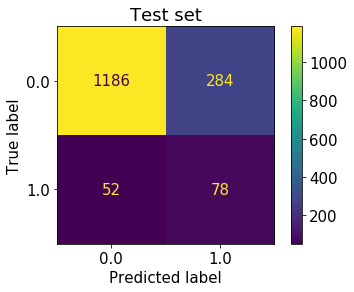

In [44]:
# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [45]:
# add feature for current liver condition

binary_df_7 = pd.read_csv('data/binary_df_7').set_index('SEQN')
binary_df_7

,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx,unknown_dx,age_0-5,age_18-49,age_50-59,age_60-69,age_70+,liver_binary
SEQN,,,,,,,,,,,,,,,,,,,,,,,,
93703.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,1,0,0,0,0,0
93704.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000,0.00000,1,0,0,0,0,0
93705.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000,0.00000,0,0,0,1,0,0
93706.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,0,1,0,0,0,0
93707.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,1.00000,0.00000,0,0,0,0,1,0
102953.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0,0.00000,0.00000,0,1,0,0,0,0
102954.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0.00000,0.00000,0,1,0,0,0,0


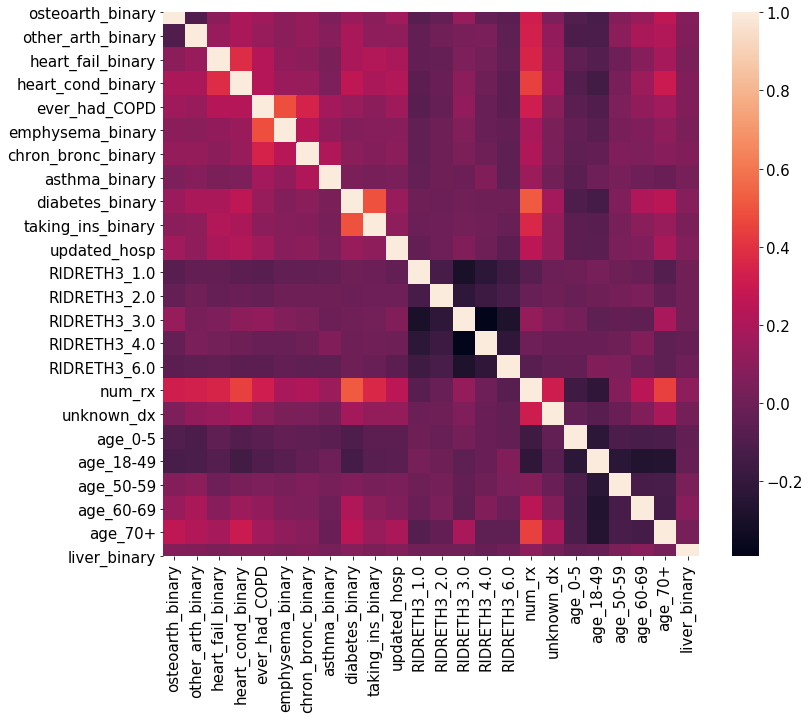

In [46]:
corr = binary_df_7.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr)

# number of rx is correlated with lots of conditions, but not more than 50%
# COPD and emphysema correlated about 50%

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.726


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.04
Test mean precision: 0.21 +/- 0.03
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.59970     5.59970
liver_binary       5.18750     5.18750
heart_fail_binary  5.14770     5.14770
chron_bronc_binary 4.99170     4.99170
taking_ins_binary  4.63170     4.63170
unknown_dx         4.52870     4.52870
ever_had_COPD      4.49430     4.49430
heart_cond_binary  3.75500     3.75500
num_rx             3.68580     3.68580
osteoarth_binary   3.56200     3.56200
asthma_binary      3.29100     3.29100
diabetes_binary    3.26500     3.26500
RIDRETH3_2.0       3.26110     3.26110
other_arth_binary  3.17620     3.17620
age_50-59          3.12680     3.12680
age_0-5            3.11990     3.11990
age_70+            3.11990     3.11990


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


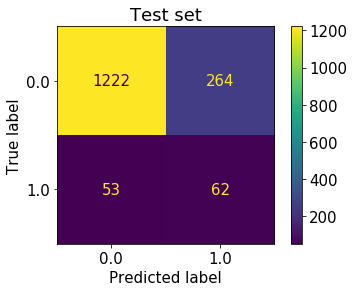

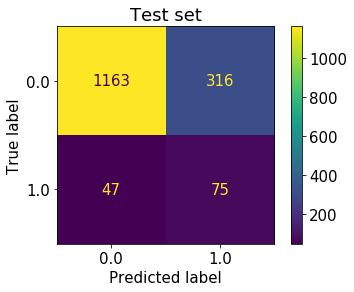

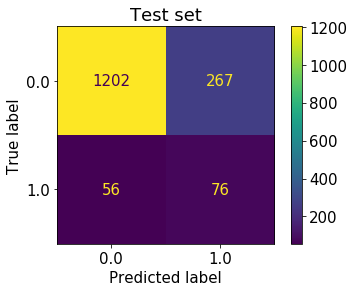

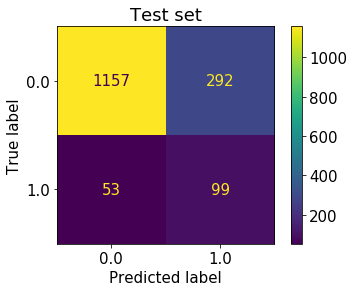

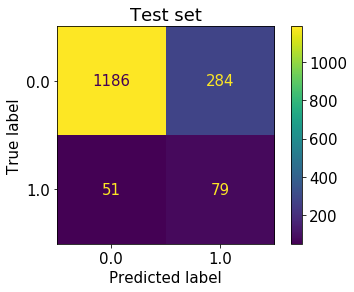

In [47]:
# define X and y

X = binary_df_7.drop(columns = ['updated_hosp'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [48]:
# check how many ppl have current liver condition
binary_df_7['liver_binary'].value_counts()

# very few, but because it has a heavy weight, let's keep it in for now

0    8760
1     134
Name: liver_binary, dtype: int64

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.74


Train mean recall: 0.6 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.59 +/- 0.04
Test mean precision: 0.22 +/- 0.03
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.43540     5.43540
liver_binary       5.02320     5.02320
heart_fail_binary  4.98340     4.98340
chron_bronc_binary 4.82740     4.82740
taking_ins_binary  4.46740     4.46740
unknown_dx         4.36440     4.36440
ever_had_COPD      4.33000     4.33000
heart_cond_binary  3.59070     3.59070
num_rx             3.52150     3.52150
osteoarth_binary   3.39770     3.39770
asthma_binary      3.12670     3.12670
diabetes_binary    3.10070     3.10070
RIDRETH3_2.0       3.09680     3.09680
other_arth_binary  3.01190     3.01190
age_50-59          2.96250     2.96250
age_0-5            2.95560     2.95560
age_70+            2.95560     2.95560
a

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


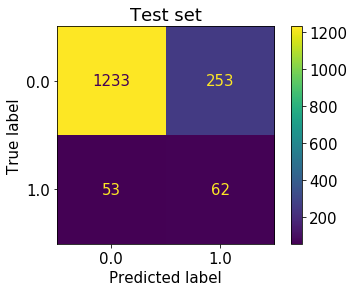

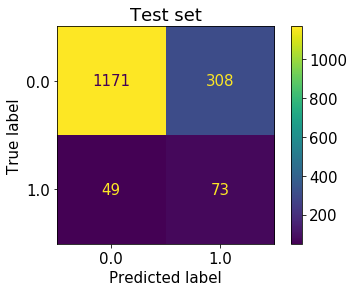

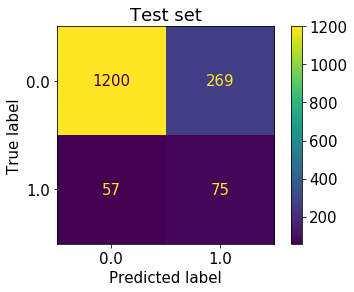

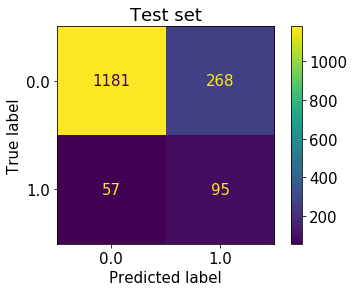

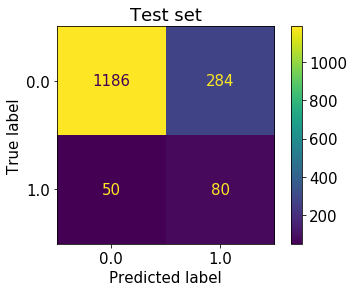

In [49]:
# try dropping column with lowest weight

X = binary_df_7.drop(columns = ['updated_hosp', 'age_18-49'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

In [50]:
binary_df_8 = pd.read_csv('data/binary_df_8').set_index('SEQN')
binary_df_8.head()

,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,updated_hosp,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx,unknown_dx,age_0-5,age_18-49,age_50-59,age_60-69,age_70+,liver_binary,recent_cancer
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,
93703.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,1,0,0,0,0,0,0
93704.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000,0.00000,1,0,0,0,0,0,0
93705.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000,0.00000,0,0,0,1,0,0,0
93706.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000,0.00000,0,1,0,0,0,0,0
93707.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0,0,0,0,0,0,0


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.728


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.21 +/- 0.03
Test mean F1: 0.31 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.61250     5.61250
liver_binary       5.20020     5.20020
heart_fail_binary  5.16050     5.16050
chron_bronc_binary 5.00450     5.00450
taking_ins_binary  4.64450     4.64450
unknown_dx         4.54140     4.54140
ever_had_COPD      4.50710     4.50710
recent_cancer      4.36850     4.36850
heart_cond_binary  3.76770     3.76770
num_rx             3.69850     3.69850
osteoarth_binary   3.57470     3.57470
asthma_binary      3.30380     3.30380
diabetes_binary    3.27780     3.27780
RIDRETH3_2.0       3.27380     3.27380
other_arth_binary  3.18890     3.18890
age_50-59          3.13950     3.13950
age_0-5            3.13270     3.13270


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


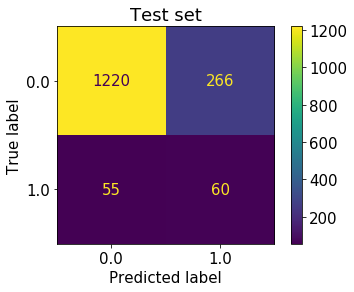

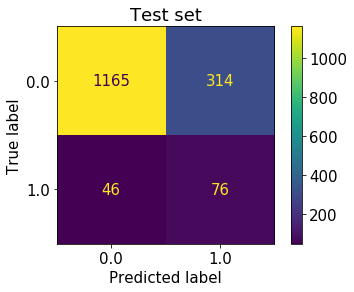

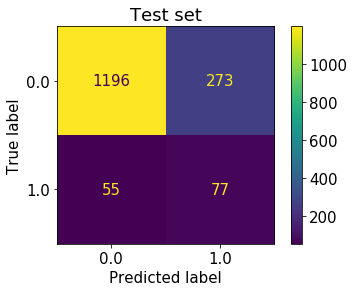

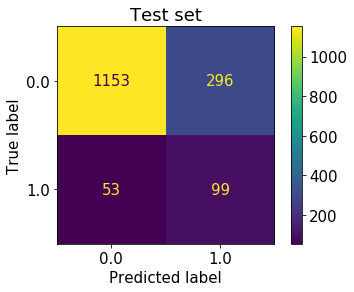

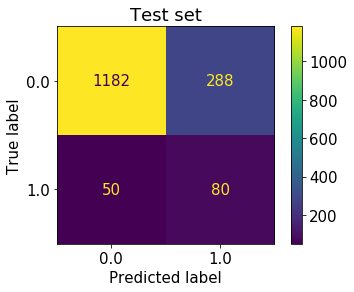

In [51]:
# try adding recent cancer dx

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.727


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.21 +/- 0.03
Test mean F1: 0.32 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.60690     5.60690
heart_fail_binary  5.15500     5.15500
chron_bronc_binary 4.99900     4.99900
taking_ins_binary  4.63900     4.63900
unknown_dx         4.53590     4.53590
ever_had_COPD      4.50160     4.50160
recent_cancer      4.36300     4.36300
heart_cond_binary  3.76220     3.76220
num_rx             3.69300     3.69300
osteoarth_binary   3.56920     3.56920
asthma_binary      3.29830     3.29830
diabetes_binary    3.27220     3.27220
RIDRETH3_2.0       3.26830     3.26830
other_arth_binary  3.18340     3.18340
age_50-59          3.13400     3.13400
age_0-5            3.12720     3.12720
age_70+            3.12720     3.12720


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


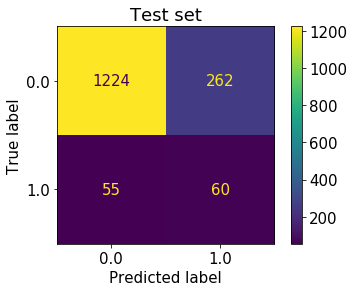

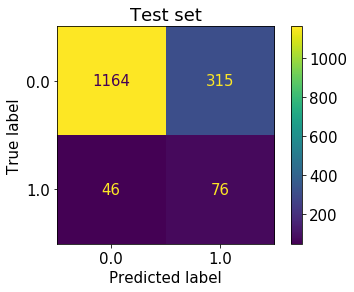

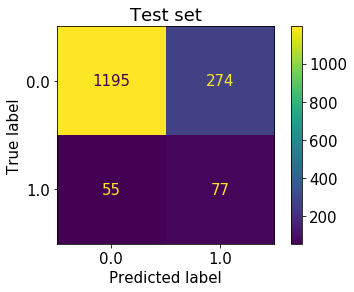

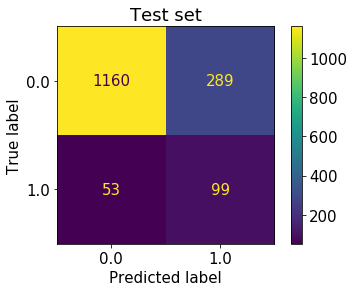

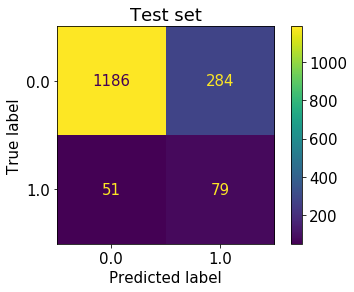

In [52]:
# try dropping liver

X = binary_df_8.drop(columns = ['updated_hosp', 'liver_binary'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# no improvement

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.741


Train mean recall: 0.6 +/- 0.01
Train mean precision: 0.22 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.59 +/- 0.03
Test mean precision: 0.21 +/- 0.02
Test mean F1: 0.31 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.44390     5.44390
heart_fail_binary  4.99200     4.99200
chron_bronc_binary 4.83590     4.83590
taking_ins_binary  4.47590     4.47590
unknown_dx         4.37290     4.37290
ever_had_COPD      4.33850     4.33850
recent_cancer      4.20000     4.20000
heart_cond_binary  3.59920     3.59920
num_rx             3.53000     3.53000
osteoarth_binary   3.40620     3.40620
asthma_binary      3.13520     3.13520
diabetes_binary    3.10920     3.10920
RIDRETH3_2.0       3.10530     3.10530
other_arth_binary  3.02040     3.02040
age_50-59          2.97100     2.97100
age_0-5            2.96410     2.96410
age_70+            2.96410     2.96410


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


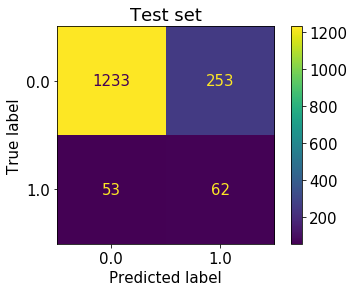

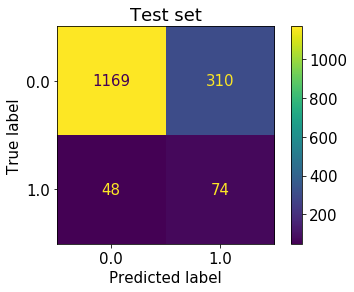

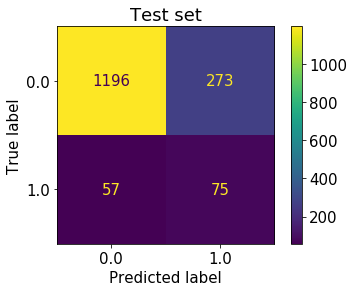

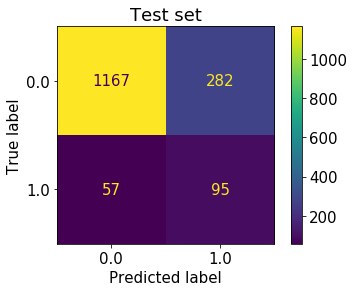

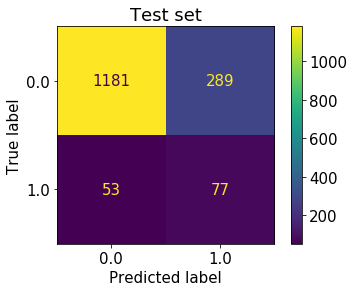

In [53]:
# try dropping liver and least weighted features

X = binary_df_8.drop(columns = ['updated_hosp', 'liver_binary', 'age_18-49'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# recall worse

Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.725


Train mean recall: 0.61 +/- 0.01
Train mean precision: 0.21 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.6 +/- 0.05
Test mean precision: 0.21 +/- 0.02
Test mean F1: 0.31 +/- 0.03


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.60180     5.60180
liver_binary       5.18950     5.18950
heart_fail_binary  5.14980     5.14980
chron_bronc_binary 4.99380     4.99380
taking_ins_binary  4.63380     4.63380
ever_had_COPD      4.49640     4.49640
recent_cancer      4.35780     4.35780
heart_cond_binary  3.75700     3.75700
num_rx             3.68780     3.68780
osteoarth_binary   3.56400     3.56400
asthma_binary      3.29310     3.29310
diabetes_binary    3.26700     3.26700
RIDRETH3_2.0       3.26310     3.26310
other_arth_binary  3.17820     3.17820
age_50-59          3.12880     3.12880
age_0-5            3.12200     3.12200
age_70+            3.12200     3.12200


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


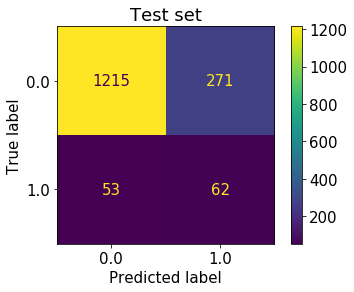

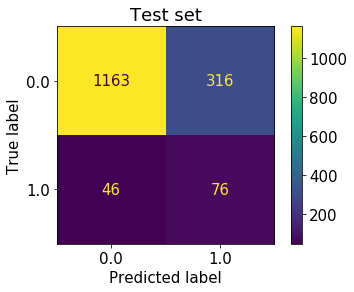

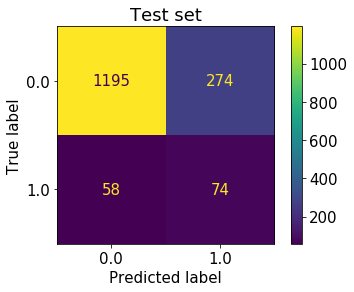

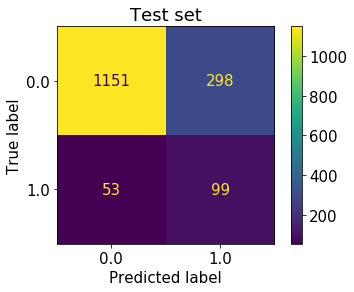

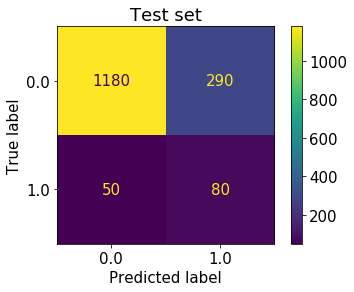

In [54]:
# test same df without 'unknown dx'

X = binary_df_8.drop(columns = ['updated_hosp', 'unknown_dx'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

k_fold_validator_2(X_training, y_training, CompNB)

# not worse

Train recall score: 0.61
Train precision score: 0.21
Train F1 score: 0.31


Holdout recall score: 0.67
Holdout precision score: 0.21
Holdout F1 score: 0.32


Text(0.5, 1.0, 'Final Model: Holdout set')

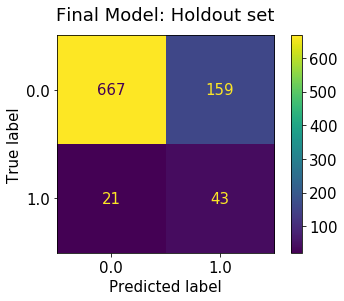

In [55]:
# test holdout set with binary_df_8 and all columns
# liver and cancer didn't seem to improve scores, but with a larger dataset they might

X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.1, random_state=807)

# try Complement Naive Bayes

CompNB = ComplementNB()

CompNB.fit(X_training, y_training)

y_pred_train = CompNB.predict(X_training)
y_pred_holdout = CompNB.predict(X_holdout)

print('Train recall score:', round(recall_score(y_training, y_pred_train), 2))
print('Train precision score:', round(precision_score(y_training, y_pred_train), 2))
print('Train F1 score:', round(f1_score(y_training, y_pred_train), 2))       
print('\n')
print('Holdout recall score:', round(recall_score(y_holdout, y_pred_holdout), 2))
print('Holdout precision score:', round(precision_score(y_holdout, y_pred_holdout), 2))
print('Holdout F1 score:', round(f1_score(y_holdout, y_pred_holdout), 2))       

plot_confusion_matrix(CompNB, X_holdout, y_holdout)
plt.title('Final Model: Holdout set', fontsize=18, pad=15)
# plt.savefig('images/final-model-holdout')

In [56]:
target_ratio = pd.DataFrame(y_holdout.value_counts(normalize=True))
target_ratio.rename(index = {0.00000: 'No', 1.00000: 'Yes'}, inplace=True)
target_ratio

,updated_hosp
No,0.92809
Yes,0.07191


Classifier: ComplementNB()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.734


Train mean recall: 0.62 +/- 0.01
Train mean precision: 0.22 +/- 0.0
Train mean F1: 0.32 +/- 0.0


Test mean recall: 0.62 +/- 0.05
Test mean precision: 0.22 +/- 0.01
Test mean F1: 0.32 +/- 0.02


Feature weights: 
                     weight  abs_weight
emphysema_binary   5.52980     5.52980
liver_binary       5.17650     5.17650
heart_fail_binary  5.13000     5.13000
chron_bronc_binary 4.98230     4.98230
taking_ins_binary  4.58340     4.58340
unknown_dx         4.53840     4.53840
ever_had_COPD      4.49530     4.49530
recent_cancer      4.45980     4.45980
heart_cond_binary  3.76380     3.76380
num_rx             3.68830     3.68830
osteoarth_binary   3.57180     3.57180
diabetes_binary    3.32320     3.32320
asthma_binary      3.26690     3.26690
RIDRETH3_2.0       3.25640     3.25640
other_arth_binary  3.18410     3.18410
age_70+            3.14580     3.14580
age_50-59          3.12110     3.12110
a

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


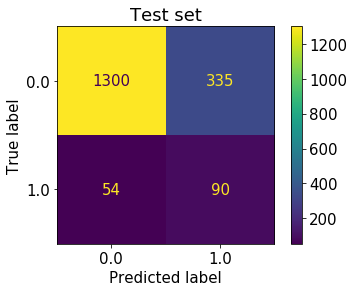

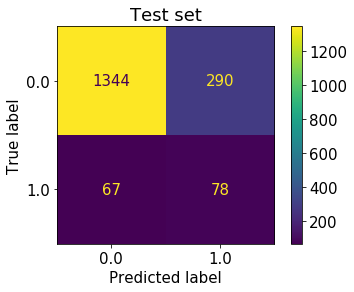

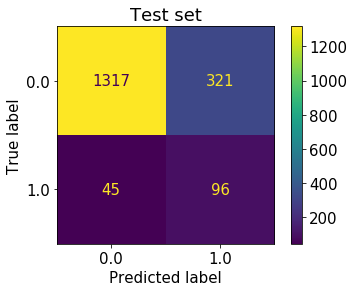

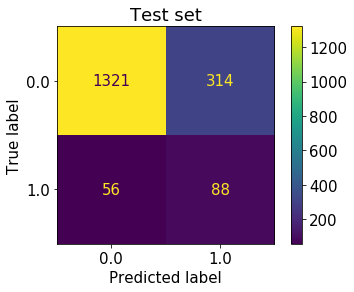

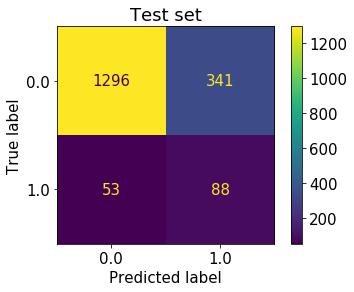

In [57]:
# test k-fold validation on entire data set with final model

k_fold_validator_2(X, y, CompNB)

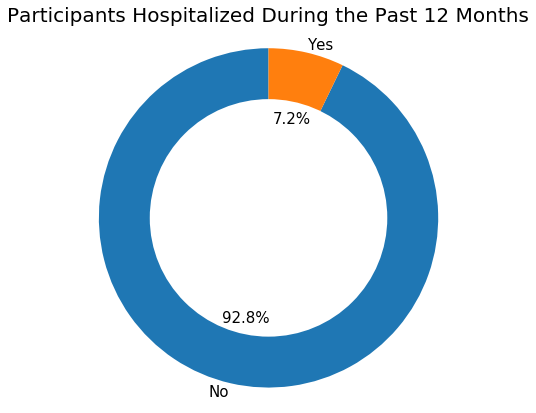

In [58]:
# plot doughnut chart to show holdout set target distribution

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(target_ratio['updated_hosp'], 
        labels=target_ratio.index,
#        colors=['tab:blue', 'tab:orange'],
        autopct='%1.1f%%',
        labeldistance=1.05,
        startangle=90,
        textprops = {"fontsize":15})
ax1.set_title('Participants Hospitalized During the Past 12 Months', pad=10, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.savefig('images/label-distribution-pie', bbox_inches='tight')

Classifier: KNeighborsClassifier()
Cross-validation folds: 5


Mean ROC-AUC Score: 0.608


Train mean recall: 0.12 +/- 0.01
Train mean precision: 0.7 +/- 0.05
Train mean F1: 0.2 +/- 0.02


Test mean recall: 0.03 +/- 0.01
Test mean precision: 0.25 +/- 0.1
Test mean F1: 0.05 +/- 0.02




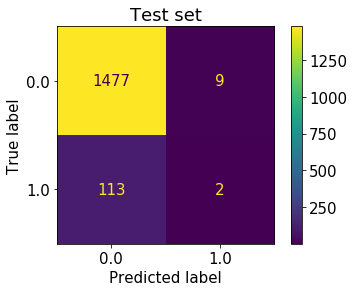

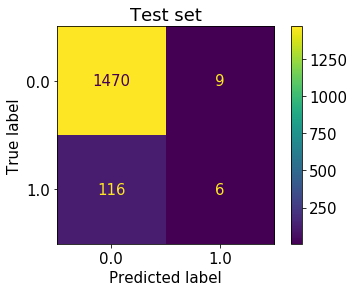

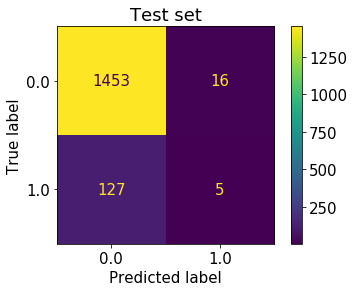

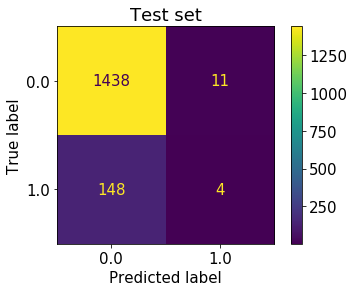

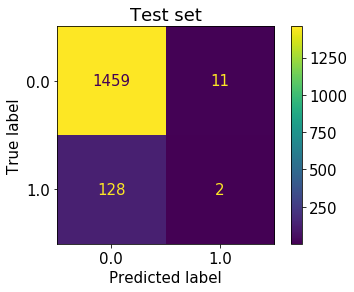

In [59]:
knn = KNeighborsClassifier()

k_fold_validator_2(X_training, y_training, knn)

# very slight improvement in test precision

In [60]:
nn = Sequential()

# Input layer with dropout
nn.add(layers.Dropout(0.3))

# First hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Second hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Third hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Output layer
nn.add(layers.Dense(1, activation='linear'))

# Compile the model
nn.compile(optimizer='SGD', 
              loss='mse',  
              metrics=['accuracy']) 

# Return the compiled model


In [61]:
y_training_array = y_training.to_numpy().reshape((8004,1))

In [62]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

In [63]:
X_train_scaled_reindex = X_train_scaled.reset_index(drop=True)
X_train_scaled_reindex

,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx,unknown_dx,age_0-5,age_18-49,age_50-59,age_60-69,age_70+,liver_binary,recent_cancer
0,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,-0.71228,-0.54674,2.57490,0.31770,-0.17506,-0.32131,-0.70294,2.95588,-0.37764,-0.36786,-0.12285,5.36234
1,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,-0.71228,1.82901,-0.38836,-0.52809,-0.17506,-0.32131,1.42260,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
2,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,2.40959,-0.31030,-0.71228,-0.54674,-0.38836,-0.10519,-0.17506,-0.32131,1.42260,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
3,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,1.40394,-0.54674,-0.38836,-0.52809,-0.17506,3.11227,-0.70294,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
4,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,1.40394,-0.54674,-0.38836,-0.52809,-0.17506,-0.32131,1.42260,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,1.40394,-0.54674,-0.38836,-0.52809,-0.17506,-0.32131,-0.70294,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
8000,-0.28850,2.93996,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,-0.71228,1.82901,-0.38836,-0.10519,-0.17506,-0.32131,1.42260,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
8001,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,2.40959,-0.31030,-0.71228,-0.54674,-0.38836,-0.52809,-0.17506,-0.32131,-0.70294,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649
8002,-0.28850,-0.34014,-0.14775,-0.27057,-0.18177,-0.10604,-0.13773,-0.31103,-0.32343,-0.16812,-0.41501,-0.31030,1.40394,-0.54674,-0.38836,-0.52809,-0.17506,-0.32131,-0.70294,-0.33831,-0.37764,-0.36786,-0.12285,-0.18649


In [64]:
# always predicting majority class, not learning anything

nn.fit(X_train_scaled_reindex, y_training_array, epochs=10, validation_split=0.1)

Epoch 1/10
226/226 [==============================] - 1s 3ms/step - loss: 0.2788 - accuracy: 0.8946 - val_loss: 0.0748 - val_accuracy: 0.9189
Epoch 2/10
226/226 [==============================] - 0s 784us/step - loss: 0.0838 - accuracy: 0.9203 - val_loss: 0.0737 - val_accuracy: 0.9189
Epoch 3/10
226/226 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.9190 - val_loss: 0.0738 - val_accuracy: 0.9189
Epoch 4/10
226/226 [==============================] - 0s 906us/step - loss: 0.0771 - accuracy: 0.9184 - val_loss: 0.0733 - val_accuracy: 0.9189
Epoch 5/10
226/226 [==============================] - 0s 887us/step - loss: 0.0777 - accuracy: 0.9176 - val_loss: 0.0734 - val_accuracy: 0.9189
Epoch 6/10
226/226 [==============================] - 0s 830us/step - loss: 0.0693 - accuracy: 0.9257 - val_loss: 0.0733 - val_accuracy: 0.9189
Epoch 7/10
226/226 [==============================] - 0s 878us/step - loss: 0.0779 - accuracy: 0.9169 - val_loss: 0.0733 - val_accuracy: 0.9

Classifier: DecisionTreeClassifier(min_samples_split=3)
Cross-validation folds: 5


Mean ROC-AUC Score: 0.472


Train mean recall: 0.45 +/- 0.01
Train mean precision: 0.99 +/- 0.0
Train mean F1: 0.62 +/- 0.01


Test mean recall: 0.15 +/- 0.03
Test mean precision: 0.28 +/- 0.04
Test mean F1: 0.19 +/- 0.03


Feature weights: 
                     weight  abs_weight
num_rx             0.23920     0.23920
heart_cond_binary  0.09880     0.09880
diabetes_binary    0.06150     0.06150
RIDRETH3_4.0       0.05900     0.05900
other_arth_binary  0.05110     0.05110
RIDRETH3_3.0       0.04890     0.04890
RIDRETH3_2.0       0.04030     0.04030
age_60-69          0.03910     0.03910
osteoarth_binary   0.03640     0.03640
unknown_dx         0.03050     0.03050
recent_cancer      0.03010     0.03010
asthma_binary      0.02980     0.02980
ever_had_COPD      0.02900     0.02900
chron_bronc_binary 0.02580     0.02580
age_70+            0.02250     0.02250
RIDRETH3_1.0       0.02220     0.02220
heart_fail

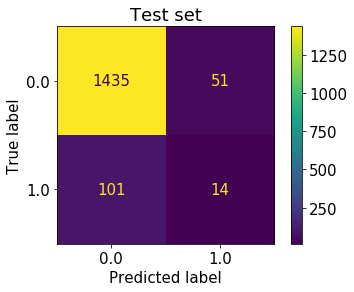

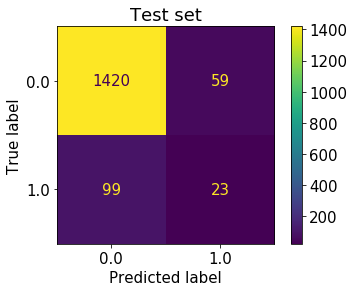

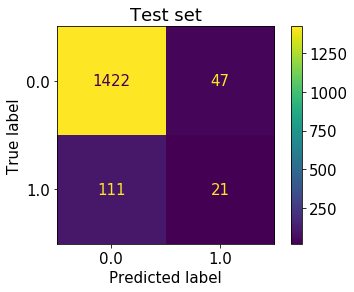

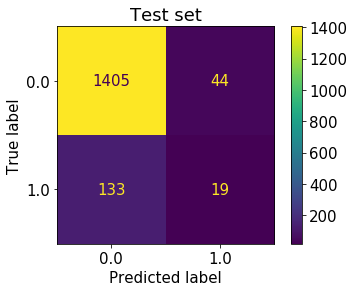

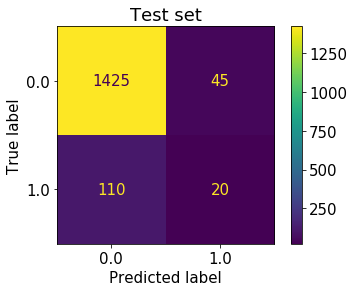

In [65]:
# try a decision tree agin

tree = DecisionTreeClassifier(min_samples_split=3)

k_fold_validator_2(X_training, y_training, tree)

Classifier: GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 6, 8],
                         'max_features': [10, 13, 16],
                         'min_samples_leaf': [10, 12, 14],
                         'min_samples_split': [8, 10, 12]})
Cross-validation folds: 5


Mean ROC-AUC Score: 0.728


Train mean recall: 0.05 +/- 0.02
Train mean precision: 0.62 +/- 0.03
Train mean F1: 0.09 +/- 0.03


Test mean recall: 0.03 +/- 0.01
Test mean precision: 0.43 +/- 0.13
Test mean F1: 0.06 +/- 0.01




AttributeError: 'GridSearchCV' object has no attribute 'coef_'

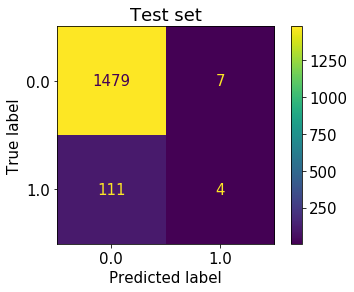

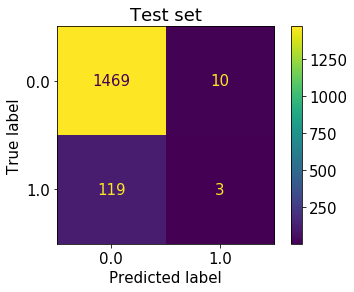

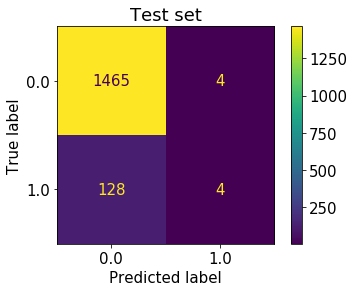

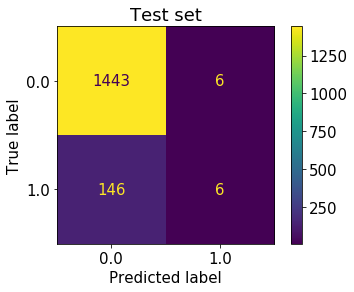

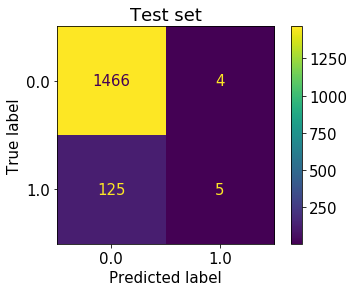

In [67]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [10, 13, 16]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)

k_fold_validator_2(X_training, y_training, tree_grid_search)

In [ ]:
tree_grid_search.best_params_

In [ ]:
tree_grid_search.best_estimator_.feature_importances_

In [ ]:
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3, scoring='recall')

k_fold_validator_2(X_training, y_training, tree_grid_search, cv=2)

In [ ]:
y_training.value_counts(normalize=True)

In [ ]:
tree_grid_search.best_params_

In [ ]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=10,
                                min_samples_leaf=10, min_samples_split=8)
forest.fit(X_training, y_training)

In [ ]:
k_fold_validator(X_training, y_training, forest, cv=2)

In [ ]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_training, y_training)

In [ ]:
CompNB = ComplementNB()

k_fold_validator_2(X_smote, y_smote, CompNB)

# smote does not help recall

In [ ]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=10,
                                min_samples_leaf=10, min_samples_split=8)

In [ ]:
k_fold_validator_2(X_smote, y_smote, forest)

# smote does help recall

In [ ]:
forest.fit(X_smote, y_smote)

y_pred = forest.predict(X_holdout)

In [ ]:
y_pred

In [ ]:
print(recall_score(y_holdout, y_pred),
precision_score(y_holdout, y_pred),
      accuracy_score(y_holdout, y_pred))